In [6]:
import os
import numpy as np
import shutil
import matplotlib.pyplot as plt
from PIL import UnidentifiedImageError
from sklearn.utils import resample
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
# Data Preprocessing
# Define preprocessing functions or use ImageDataGenerator for real-time augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest')

# Load the dataset
train_generator = train_datagen.flow_from_directory(
    directory="D:/DATASET/CNN/ballooning/train",
    target_size=(224, 224),  # ResNet50 input size
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    seed=42)

Found 7973 images belonging to 2 classes.


In [3]:
# Paths to class directories
class1_dir = "D:/DATASET/CNN/ballooning/train/1"
class0_dir = "D:/DATASET/CNN/ballooning/train/0"

# Get list of filenames in each class directory
class1_files = [os.path.join(class1_dir, filename) for filename in os.listdir(class1_dir)]
class0_files = [os.path.join(class0_dir, filename) for filename in os.listdir(class0_dir)]

# Calculate the average number of images per class
avg_images_per_class = (len(class0_files) + len(class1_files)) // 2

In [4]:
# Create a directory for the balanced dataset
balanced_dir = "D:/DATASET/CNN/ballooning/balanced_train"
os.makedirs(balanced_dir, exist_ok=True)

# Create subdirectories for each class within the balanced dataset directory
balanced_class0_dir = os.path.join(balanced_dir, "0")
os.makedirs(balanced_class0_dir, exist_ok=True)

balanced_class1_dir = os.path.join(balanced_dir, "1")
os.makedirs(balanced_class1_dir, exist_ok=True)

In [5]:
# Oversample class 0
class0_oversampled = resample(class0_files, replace=True, n_samples=avg_images_per_class, random_state=42)

# Downsample class 1
class1_downsampled = resample(class1_files, replace=False, n_samples=avg_images_per_class, random_state=42)

In [6]:
# Copy balanced dataset images to the corresponding class directories
for i, img_path in enumerate(class1_downsampled):
    shutil.copy(img_path, os.path.join(balanced_class1_dir, f"{i}.jpg"))

for i, img_path in enumerate(class0_oversampled):
    shutil.copy(img_path, os.path.join(balanced_class0_dir, f"{i}.jpg"))


In [7]:
# Create labels for balanced data
y_balanced = np.array([0] * len(class1_downsampled) + [1] * len(class0_oversampled))

Number of images before resampling:
Class 0: 1274
Class 1: 6701

Number of images after resampling:
Class 0: 3987
Class 1: 3987


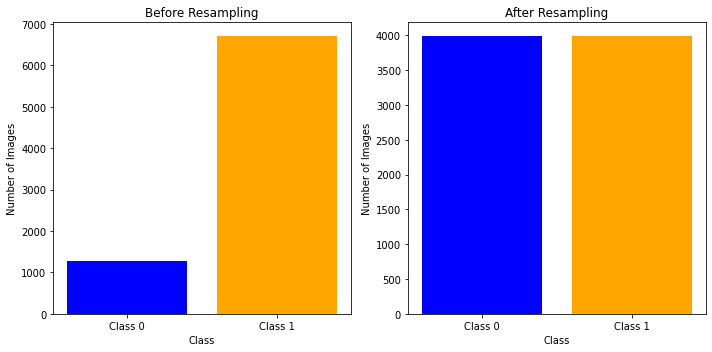

In [9]:
# Display the number of images before and after resampling
print("Number of images before resampling:")
print("Class 0:", len(class0_files))
print("Class 1:", len(class1_files))
print("\nNumber of images after resampling:")
print("Class 0:", len(class0_oversampled))
print("Class 1:", len(class1_downsampled))

# Plot histograms
plt.figure(figsize=(10, 5))

# Before resampling
plt.subplot(1, 2, 1)
plt.bar(['Class 0', 'Class 1'], [len(class0_files), len(class1_files)], color=['blue', 'orange'])
plt.title('Before Resampling')
plt.xlabel('Class')
plt.ylabel('Number of Images')

# After resampling
plt.subplot(1, 2, 2)
plt.bar(['Class 0', 'Class 1'], [len(class0_oversampled), len(class1_downsampled)], color=['blue', 'orange'])
plt.title('After Resampling')
plt.xlabel('Class')
plt.ylabel('Number of Images')

plt.tight_layout()
plt.show()

In [10]:
# Data Preprocessing
# Define preprocessing functions or use ImageDataGenerator for real-time augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.8, 1.2],
    fill_mode='nearest')


In [11]:
# Load the balanced dataset using ImageDataGenerator
train_generator = train_datagen.flow_from_directory(
    directory=balanced_dir,
    target_size=(224, 224),  # ResNet50 input size
    batch_size=32,
    class_mode='binary',
    shuffle=True,
    seed=42)

Found 7971 images belonging to 2 classes.


In [12]:
# Load ResNet50 base model without top layers
base_model = ResNet50(weights='imagenet', include_top=False)

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

# Combine base model and custom layers
model = Model(inputs=base_model.input, outputs=predictions)

In [13]:
# Freeze the layers of base model
for layer in base_model.layers:
    layer.trainable = False

In [14]:
# Compile the model
model.compile(optimizer=Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [15]:
# Train the model using the balanced dataset
history = model.fit(train_generator, epochs=10, validation_data=train_generator)

Epoch 1/10
250/250 [==============================] - 1078s 4s/step - loss: 0.4459 - accuracy: 0.7912 - val_loss: 0.3047 - val_accuracy: 0.8850
Epoch 2/10
250/250 [==============================] - 1183s 5s/step - loss: 0.3302 - accuracy: 0.8580 - val_loss: 0.3006 - val_accuracy: 0.8904
Epoch 3/10
250/250 [==============================] - 1190s 5s/step - loss: 0.3022 - accuracy: 0.8755 - val_loss: 0.2645 - val_accuracy: 0.8993
Epoch 4/10
250/250 [==============================] - 1181s 5s/step - loss: 0.2848 - accuracy: 0.8842 - val_loss: 0.2864 - val_accuracy: 0.8922
Epoch 5/10
250/250 [==============================] - 1170s 5s/step - loss: 0.2569 - accuracy: 0.8897 - val_loss: 0.3320 - val_accuracy: 0.8740
Epoch 6/10
250/250 [==============================] - 1171s 5s/step - loss: 0.2691 - accuracy: 0.8882 - val_loss: 0.2541 - val_accuracy: 0.8842
Epoch 7/10
250/250 [==============================] - 1187s 5s/step - loss: 0.2587 - accuracy: 0.8937 - val_loss: 0.3161 - val_accuracy:

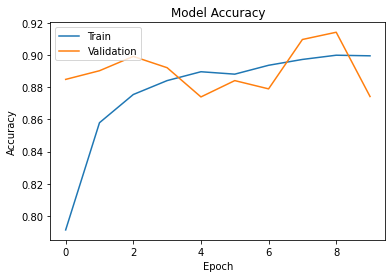

In [18]:
# Plot training history
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [16]:
model.save("D:/DATASET/Models/model_ballooning.h5")

In [7]:
from tensorflow.keras.models import load_model

# Load the model using TensorFlow's built-in method
model = load_model('D:/DATASET/Models/model_ballooning.h5')

In [17]:
import numpy as np
import cv2
from skimage import exposure, color, filters, morphology, measure
from PIL import Image
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    """Load and preprocess the input image."""
    # Load the image
    image = Image.open(image_path)
    # Resize the image to 299x299
    image_resized = image.resize((299, 299))
    return np.array(image_resized)

def enhance_contrast(image):
    """Enhance contrast of the input image."""
    # Perform contrast enhancement (e.g., histogram equalization)
    img_equalized = exposure.equalize_hist(image)
    return img_equalized

def detect_spots(image):
    """Detect dark circular spots representing cytoskeleton debris."""
    # Convert image to grayscale
    gray_image = color.rgb2gray(image)
    # Enhance contrast
    contrast_enhanced_image = enhance_contrast(gray_image)
    # Apply thresholding
    threshold = filters.threshold_otsu(contrast_enhanced_image)
    binary_image = contrast_enhanced_image > threshold
    # Morphological operations
    binary_image = morphology.binary_closing(binary_image, morphology.disk(5))
    # Label regions
    labeled_image = measure.label(binary_image)
    # Find circular spots
    spots = np.zeros_like(binary_image)
    for region in measure.regionprops(labeled_image):
        if region.area > 50:
            spots[region.coords[:, 0], region.coords[:, 1]] = 1
    return spots

def annotate_image(image, spots):
    """Annotate the detected spots on the image."""
    # Overlay green annotations on the image at the positions of detected spots
    annotated_image = np.copy(image)
    annotated_image[spots == 1] = [0, 255, 0]  # Set color of spots to green
    return annotated_image

def predict_nash_score(model, img_preprocessed):
    """Predict the NASH score using the preprocessed image and the model."""
    # Add batch dimension
    img_preprocessed = np.expand_dims(img_preprocessed, axis=0)

    # Make prediction using the model
    prediction = model.predict(img_preprocessed)
    # Return the predicted class and probability
    predicted_class = np.argmax(prediction)
    probability = np.max(prediction)
    return predicted_class, probability

def display_images(original_image_path, annotated_image):
    """Display the original and annotated images side by side."""
    # Read the original image
    original_image = cv2.imread(original_image_path)

    plt.figure(figsize=(10, 5))
    
    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Display the annotated image
    plt.subplot(1, 2, 2)
    plt.imshow(annotated_image, cmap='gray')
    plt.title("Annotated Image")
    plt.axis('off')

    # Show the plot
    plt.show()


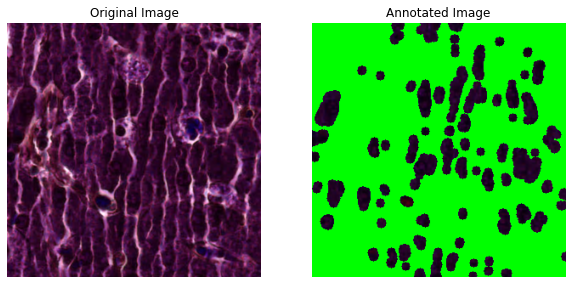

1/1 [==============================] - 0s 153ms/step
1: Ballooning present
Probability: 0.999999


In [18]:
# Load and preprocess the image
image_path = "D:/DATASET/CNN/ballooning/balanced_train/0/120.jpg"
img_preprocessed = preprocess_image(image_path)

# Detect dark circular spots
spots = detect_spots(img_preprocessed)

# Annotate the image with detected spots
annotated_image = annotate_image(img_preprocessed, spots)

# Display the images
display_images(image_path, annotated_image)

# Predict the NASH score using the model
predicted_class, probability = predict_nash_score(model, img_preprocessed)

# Output the predicted class and probability
if probability < 1:
    print("1: Ballooning present")
else:
    print("0: Ballooning absent")

print("Probability:", probability)

In [36]:
import numpy as np
import cv2

def preprocess_image(image_path):
    """Load and preprocess the input image."""
    # Load the image
    image = cv2.imread(image_path)
    return image

def extract_patches(image, patch_size=(299, 299), stride=150):
    """Extract patches from the input image."""
    patches = []
    height, width, _ = image.shape
    for y in range(0, height - patch_size[0] + 1, stride):
        for x in range(0, width - patch_size[1] + 1, stride):
            patch = image[y:y+patch_size[0], x:x+patch_size[1]]
            patches.append(patch)
    return patches

def preprocess_patches(patches):
    """Preprocess the patches for prediction."""
    preprocessed_patches = []
    for patch in patches:
        # Resize the patch to 299x299
        resized_patch = cv2.resize(patch, (299, 299))
        # Normalize pixel values
        normalized_patch = resized_patch.astype(np.float32) / 255.0
        # Add batch dimension
        preprocessed_patches.append(np.expand_dims(normalized_patch, axis=0))
    return preprocessed_patches

def predict_patch_probabilities(model, preprocessed_patches):
    """Predict the probability of ballooning for each patch."""
    probabilities = []
    for patch in preprocessed_patches:
        prediction = model.predict(patch)
        if len(prediction.shape) == 1:  # If only one probability is returned
            probabilities.append(prediction[0])  # Use the single probability
        else:
            probabilities.append(prediction[0][0])  # Probability of class 0 (no ballooning)
        print("Predict: ", prediction)    
    return probabilities

def predict_nash_score(image_path, model):
    """Predict the NASH score for the input image."""
    # Load and preprocess the image
    image = preprocess_image(image_path)
    
    # Extract patches from the image
    patches = extract_patches(image)
    
    # Preprocess the patches for prediction
    preprocessed_patches = preprocess_patches(patches)
    
    # Predict the probability of ballooning for each patch
    probabilities = predict_patch_probabilities(model, preprocessed_patches)
    
    # Calculate the average probability
    average_probability = np.mean(probabilities)
    
    return average_probability

In [38]:
# Example usage
image_path = "D:/Testing (Triya ma'am)/Hematoxylin eosin staining for scoring at 20X and 40x/NASH_40x/10.jpeg"
average_probability = predict_nash_score(image_path, model)
print("Average probability of ballooning:", average_probability)
# Output the predicted class and probability
if average_probability < 1:
    print("1: Ballooning present")
else:
    print("0: Ballooning absent")

print("Probability:", average_probability)

1/1 [==============================] - 0s 148ms/step
Predict:  [[1.]]
1/1 [==============================] - 0s 188ms/step
Predict:  [[1.]]
1/1 [==============================] - 0s 212ms/step
Predict:  [[1.]]
1/1 [==============================] - 0s 180ms/step
Predict:  [[1.]]
1/1 [==============================] - 0s 119ms/step
Predict:  [[1.]]
1/1 [==============================] - 0s 170ms/step
Predict:  [[1.]]
1/1 [==============================] - 0s 209ms/step
Predict:  [[1.]]
1/1 [==============================] - 0s 140ms/step
Predict:  [[1.]]
1/1 [==============================] - 0s 160ms/step
Predict:  [[0.99999994]]
1/1 [==============================] - 0s 195ms/step
Predict:  [[0.99999994]]
1/1 [==============================] - 0s 153ms/step
Predict:  [[0.9999999]]
1/1 [==============================] - 0s 169ms/step
Predict:  [[1.]]
1/1 [==============================] - 0s 136ms/step
Predict:  [[1.]]
1/1 [==============================] - 0s 166ms/step
Predict:  [[1.

In [35]:
import numpy as np
import cv2
from skimage import exposure, color, filters, morphology, measure
from PIL import Image
import matplotlib.pyplot as plt

def preprocess_image(image_path):
    """Load and preprocess the input image."""
    # Load the image
    image = Image.open(image_path)
    # Resize the image to 299x299
    image_resized = image.resize((299, 299))
    return np.array(image_resized)

def enhance_contrast(image):
    """Enhance contrast of the input image."""
    # Perform contrast enhancement (e.g., histogram equalization)
    img_equalized = exposure.equalize_hist(image)
    return img_equalized

def detect_spots(image):
    """Detect dark circular spots representing cytoskeleton debris."""
    # Convert image to grayscale
    gray_image = color.rgb2gray(image)
    # Enhance contrast
    contrast_enhanced_image = enhance_contrast(gray_image)
    # Apply thresholding
    threshold = filters.threshold_otsu(contrast_enhanced_image)
    binary_image = contrast_enhanced_image > threshold
    # Morphological operations
    binary_image = morphology.binary_closing(binary_image, morphology.disk(5))
    # Label regions
    labeled_image = measure.label(binary_image)
    # Find circular spots
    spots = np.zeros_like(binary_image)
    for region in measure.regionprops(labeled_image):
        if region.area > 50:
            spots[region.coords[:, 0], region.coords[:, 1]] = 1
    return spots

def annotate_image(image, spots):
    """Annotate the detected spots on the image."""
    # Overlay green annotations on the image at the positions of detected spots
    annotated_image = np.copy(image)
    annotated_image[spots == 1] = [0, 255, 0]  # Set color of spots to green
    return annotated_image

def predict_nash_score(model, img_preprocessed):
    """Predict the NASH score using the preprocessed image and the model."""
    # Make prediction using the model
    prediction = model.predict(img_preprocessed)
    # Return the predicted class and probability
    predicted_class = np.argmax(prediction)
    
    print("predicted class: ", predicted_class)
    probability = np.max(prediction)
    
    print("probability: ", probability)
    return predicted_class, probability

def display_images(original_image_path, annotated_image):
    """Display the original and annotated images side by side."""
    # Read the original image
    original_image = cv2.imread(original_image_path)

    plt.figure(figsize=(10, 5))
    
    # Display the original image
    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')
    plt.title("Original Image")
    plt.axis('off')

    # Display the annotated image
    plt.subplot(1, 2, 2)
    plt.imshow(annotated_image, cmap='gray')
    plt.title("Annotated Image")
    plt.axis('off')

    # Show the plot
    plt.show()

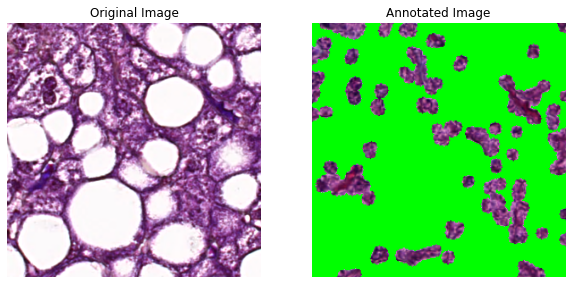

ValueError: in user code:

    File "C:\Users\JUHI\anaconda3\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\JUHI\anaconda3\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\JUHI\anaconda3\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\JUHI\anaconda3\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "C:\Users\JUHI\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\JUHI\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 235, in assert_input_compatibility
        raise ValueError(

    ValueError: Exception encountered when calling layer 'model' (type Functional).
    
    Input 0 of layer "conv1_pad" is incompatible with the layer: expected ndim=4, found ndim=3. Full shape received: (32, 224, 3)
    
    Call arguments received by layer 'model' (type Functional):
      • inputs=tf.Tensor(shape=(32, 224, 3), dtype=uint8)
      • training=False
      • mask=None


In [36]:
# Path to the user input image
image_path = "D:/DATASET/CNN/ballooning/balanced_train/1/9.jpg"

# Preprocess the image
img_preprocessed = preprocess_image(image_path)

# Detect dark circular spots
spots = detect_spots(img_preprocessed)

# Annotate the image with detected spots
annotated_image = annotate_image(img_preprocessed, spots)

# Display the images
display_images(image_path, annotated_image)

# Predict the NASH score using the model
predicted_class, probability = predict_nash_score(model, img_preprocessed)

# Output the predicted class and probability
print("Predicted Class:", predicted_class)
print("Probability:", probability)

In [ ]:
# Example usage
image_path = "D:/DATASET/CNN/ballooning/balanced_train/1/37.jpg"
predicted_class, probability = make_prediction_for_image(image_path)
print("Predicted Class:", predicted_class)
print("Probability:", probability)

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from skimage import transform

def load_image(image_path):
    """Load and display the image."""
    img = cv2.imread(image_path)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    return img

def select_roi(img, x, y, w, h):
    """Extract ROI from the image."""
    roi = img[y:y+h, x:x+w]
    plt.imshow(cv2.cvtColor(roi, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    return roi

def preprocess_roi(roi):
    """Preprocess the ROI for model prediction."""
    roi = transform.resize(roi, (224, 224))  # Resize to match model input size
    roi = np.expand_dims(roi, axis=0)  # Add batch dimension
    roi = preprocess_input(roi)  # Preprocess input for ResNet50
    return roi

def classify_roi(roi):
    """Classify ROI using ResNet50."""
    predictions = model.predict(roi)
    decoded_predictions = decode_predictions(predictions, top=1)[0]  # Get top prediction
    print("Predicted class:", decoded_predictions[0][1])  # Display predicted class label
    return decoded_predictions[0][1]

def generate_heatmap(roi):
    """Generate heatmap (example: not implemented)."""
    heatmap = np.random.rand(224, 224)  # Example heatmap, replace with actual implementation
    plt.imshow(heatmap, cmap='hot')
    plt.axis('off')
    plt.show()

def calculate_nash_score(prediction):
    """Calculate NASH score based on prediction."""
    nash_score = 1 if "ballooning" in prediction.lower() else 0
    print("NASH Score:", nash_score)
    return nash_score

def make_prediction(roi):
    """Make prediction using the pre-trained model."""
    predictions = model.predict(roi)
    decoded_predictions = decode_predictions(predictions, top=1)[0]  # Get top prediction
    return decoded_predictions[0][1]

In [ ]:
# Example usage
image_path = "D:/DATASET/CNN/ballooning/balanced_train/1/37.jpg"
img = load_image(image_path)
#roi = select_roi(img, 100, 100, 200, 200)
#roi_processed = preprocess_roi(roi)
#prediction = classify_roi(roi_processed)
prediction = make_prediction(roi_processed)
print("Prediction:", prediction)
generate_heatmap(roi_processed)
calculate_nash_score(prediction)